# Simple text classification using ```scikit-learn```

## Import packages


In [5]:
# system tools
import os
import sys
sys.path.append("..")

# data munging tools
import pandas as pd
import utils.classifier_utils as clf

# Machine learning stuff
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, ShuffleSplit
from sklearn import metrics

# Visualisation
import matplotlib.pyplot as plt

## Reading in the data

Our data is already in a tabular format, so we're going to load it using ```pandas```

In [6]:
filename = os.path.join("..", "data", "fake_or_real_news.csv")

data = pd.read_csv(filename, index_col=0)

In [7]:
# creating new variables to work with
X = data["text"]
y = data["label"]

## Train-test split

Looking back at the code from last week, use the ```train_test_split()``` function to create an 80/20 split in the data.

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X,          # texts for the model
                                                    y,          # classification labels
                                                    test_size=0.2,   # create an 80/20 split
                                                    random_state=42) # random state for reproducibility

## Vectorizing and Feature Extraction

__Create vectorizer object__

Next, you want to create a vectorizer object. I suggest the following parameters:

- TfidfVectorizer on unigrams and bigrams;
- make everything lowercase; 
- remove top and bottom 5% of words; 
- keep the top 500 features.

In [21]:
vectorizer = TfidfVectorizer(ngram_range = (1,2),     # unigrams and bigrams (1 word (e.g. York) and 2 word units (e.g. New York))
                             lowercase =  True,       # why use lowercase?
                             max_df = 0.95,           # remove very common words
                             min_df = 0.05,           # remove very rare words
                             max_features = 500)      # keep only top 500 features

This vectorizer is then used to turn all of our documents into a vector of numbers, instead of text.

In [22]:
# first we fit the vectorizer to the training data...
X_train_feats = vectorizer.fit_transform(X_train)

#... then transform our test data
X_test_feats = vectorizer.transform(X_test)

# get feature names if needed
feature_names = vectorizer.get_feature_names_out()

## Classifying and predicting

We now have to 'fit' the classifier to our data. This means that the classifier takes our data and finds correlations between features and labels.

These correlations are then the *model* that the classifier learns about our data. This model can then be used to predict the label for new, unseen data.

__Simple neural network__

We can define simple NN classifiers using the ```MLPClassifier``` class in ```scikit-learn```. I've done that for you here - can you see how it's been put together?

For more information, check out the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.neural_network.MLPClassifier.html).

In [27]:
classifier = MLPClassifier(activation = "logistic",
                           hidden_layer_sizes = (20,), # after each comma is a new hidden layer - we typically go from higher to lower
                           max_iter=1000, # how many times it trains (goes through the steps)
                           random_state = 42)

In [28]:
classifier.fit(X_train_feats, y_train)

MLPClassifier(activation='logistic', hidden_layer_sizes=(20,), max_iter=1000,
              random_state=42)

__Get predictions__

We want to use our trained model to get predicted labels on our test data.

In [29]:
# making predictions using the classifier
y_pred = classifier.predict(X_test_feats)

# printing the predictions
print(y_pred[:20])

['FAKE' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'REAL' 'REAL'
 'REAL' 'REAL' 'REAL' 'FAKE' 'FAKE' 'FAKE' 'FAKE' 'REAL' 'FAKE' 'FAKE']


## Evaluate

We can also do some quick calculations, in order to assess just how well our model performs.

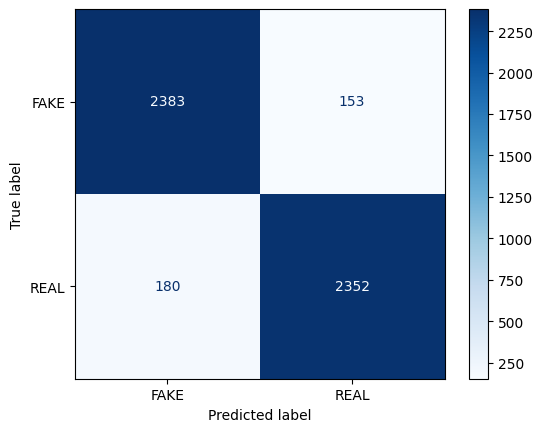

In [30]:
metrics.ConfusionMatrixDisplay.from_estimator(classifier,           # the classifier name
                                            X_train_feats,          # the training features
                                            y_train,                # the training labels
                                            cmap=plt.cm.Blues,      # make the colours prettier
                                            labels=["FAKE", "REAL"])# the labels in your data arranged alphabetically

__Calculating metrics__

We can use the same built-in classification report from ```scikit-learn``` to get the classification report for our model.

In [15]:
# given the labels in the test data and the predictions on the model... how is the model performing?
classifier_metrics = metrics.classification_report(y_test, y_pred)
print(classifier_metrics)

              precision    recall  f1-score   support

        FAKE       0.91      0.86      0.88       628
        REAL       0.87      0.92      0.89       639

    accuracy                           0.89      1267
   macro avg       0.89      0.89      0.89      1267
weighted avg       0.89      0.89      0.89      1267



__Plotting loss curves__

If our model is learning well, we should see a smooth, steep downwards slope which tapers off towards a plateau. 

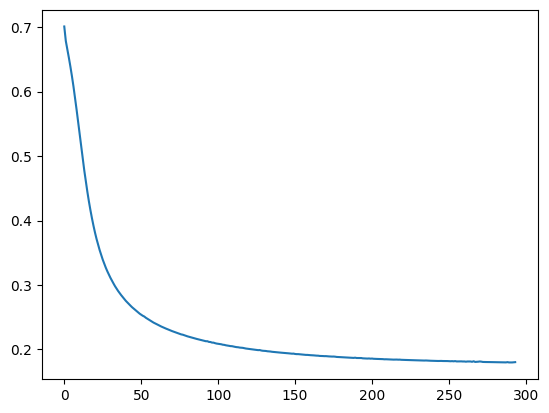

In [16]:
plt.plot(classifier.loss_curve_)

# the y axis is the number of times it runs through the steps (trains)

## Save models

As last week, it's possible to save an ```MLPClassifier``` model for later use using the library ```joblib```.

In [13]:
from joblib import dump, load
dump(classifier, "LR_classifier.joblib")
dump(vectorizer, "tfidf_vectorizer.joblib")

['tfidf_vectorizer.joblib']

We can restart the kernel for our notebook to see how that works:

In [1]:
from joblib import dump, load
loaded_clf = load("LR_classifier.joblib")
loaded_vect = load("tfidf_vectorizer.joblib")

In [2]:
sentence = "Hilary Clinton is a crook who eats babies!"

In [3]:
test_sentence = loaded_vect.transform([sentence])
loaded_clf.predict(test_sentence)

array(['REAL'], dtype='<U4')